In [23]:
import logging
from langdetect import detect
import warnings
from tqdm import tqdm
from ktrain import text 
from flair.data import Sentence
from flair.models import SequenceTagger
import pandas as pd

from galvasr2.align.spark.align_lib import load_audio_id_text_id_mapping, load_transcripts


warnings.filterwarnings("ignore")

spark = SparkSession.builder \
                      .master("local[*]") \
                      .appName("NER") \
                      .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
                      .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
                      .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
                      .config("spark.driver.memory", "40g")\
                      .config("spark.executor.memory", "40g")\
                      .config("spark.rpc.askTimeout", "480s")\
                      .config("spark.executor.heartbeatInterval", "20000ms")\
                      .config("spark.eventLog.enabled", "true")\
                      .getOrCreate()

In [ ]:
%%time
# spark.sparkContext.setLogLevel("INFO") # "ALL" for very verbose logging                                                                                                                                   
logging.getLogger("py4j").setLevel(logging.ERROR)
catalogue_df = load_audio_id_text_id_mapping(spark, "gs://the-peoples-speech-west-europe/archive_org/Mar_7_2021/CC_BY_SA_EXPANDED_LICENSES_FILTERED_ACCESS.jsonl.gz")
training_sample_rows = catalogue_df.collect()

# Comment this out to load everything. It might takes ~15 minute, in my experience, on an 8 core machine.
print(len(training_sample_rows))

training_sample_rows = training_sample_rows[:500]
transcripts_df = load_transcripts(spark,
                                  "gs://the-peoples-speech-west-europe/archive_org/Mar_7_2021/CC_BY_SA_EXPANDED_LICENSES_FILTERED_ACCESS",
                                  training_sample_rows)
transcripts_pdf = transcripts_df.toPandas()
print(transcripts_pdf.count())
transcripts_pdf.head()

76627


In [ ]:
%%time
def detect_lan(row):
    try:
        return detect(row)
    except:
        return 'problem'
transcripts_pdf['language'] = transcripts_pdf['transcript'].apply(detect_lan)
transcripts_pdf.head()

In [ ]:
transcripts_pdf['language'].value_counts().plot(kind='bar')

In [ ]:
transcripts_pdf['language'].value_counts()

## Zero shot classification

In [10]:
%%time
zsl = text.ZeroShotClassifier()
labels=['politics', 'elections', 'sports', 'films', 'television', 'artificial intelligence',
       'food', 'healthy', 'Information technology', 'financials', 'communication services',
       'mlcommons']
def get_top_class(row):
    try:
        row = row[:1500]
        classification = zsl.predict(row, labels=labels, include_labels=True, batch_size=1, multilabel=False)
        classification.sort(key=lambda tup: tup[1])
        return classification[-1][0]
    except:
        return 'problem'
transcripts_pdf['classification'] = transcripts_pdf['transcript'].apply(get_top_class)
transcripts_pdf.head()

CPU times: user 18min 4s, sys: 1min 52s, total: 19min 56s
Wall time: 9min 14s


,transcript,text_document_id,identifier,language,classification
0,good morning good morning good morning the c...,gov.house.ogr.ns.20091001.auto.srt,gov.house.ogr.ns.20091001,en,communication services
1,[Music] call to order the regular meeting of t...,51525_captions.srt,om-400-51525,en,television
2,finally this subcommittee finally this subcomm...,gov.house.ogr.fw.20090708.1.auto.srt,gov.house.ogr.fw.20090708.1,en,politics
3,Good morning everyone. The legislative hearing...,hrs09RES1324_080515.asr.srt,hrs09RES1324_080515,en,food
4,good morning the Subcommittee on good morning ...,gov.house.ogr.fw.20100727.1.auto.srt,gov.house.ogr.fw.20100727.1,en,communication services


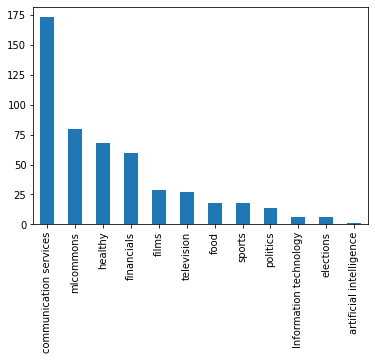

In [11]:
transcripts_pdf['classification'].value_counts().plot(kind='bar')

## NER with hugginface (flair)

In [13]:
%%time
# load tagger
tagger = SequenceTagger.load("flair/ner-english-ontonotes-fast")

ner_entities = {
    'CARDINAL':[],
    'DATE':[],
    'EVENT':[],
    'FAC':[],
    'GPE':[],
    'LANGUAGE':[],
    'LAW':[],
    'LOC':[],
    'MONEY':[],
    'NORP':[],
    'ORDINAL':[],
    'ORG':[],
    'PERCENT':[],
    'PERSON':[],
    'PRODUCT':[],
    'QUANTITY':[],
    'TIME':[],
    'WORK_OF_ART':[]
}
tagger = SequenceTagger.load("flair/ner-english-ontonotes-fast")
def get_top_class(tagger, row):
    try:
        sentence = Sentence(row)
        tagger.predict(sentence)
        for entity in sentence.get_spans('ner'):
            ner_entities[entity.tag].append(entity.text) 
    except:
        return 'problem'
transcripts = transcripts_pdf['transcript'].values

2021-05-28 18:00:30,264 loading file /root/.flair/models/ner-english-ontonotes-fast/0d55dd3b912da9cf26e003035a0c269a0e9ab222f0be1e48a3bbba3a58c0fed0.c9907cd5fde3ce84b71a4172e7ca03841cd81ab71d13eb68aa08b259f57c00b6
CPU times: user 3.16 s, sys: 646 ms, total: 3.81 s
Wall time: 3.91 s


In [14]:
%%time
for i in tqdm(range(len(transcripts))):
    get_top_class(tagger, transcripts[i][:12000])

100%|██████████| 500/500 [16:24<00:00,  1.97s/it]

CPU times: user 11min 31s, sys: 4min 54s, total: 16min 25s
Wall time: 16min 24s


In [15]:
df_ner = pd.DataFrame.from_dict(ner_entities, orient='index').T
df_ner.head()

,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
0,ninety five,five business days,New Year,the D.H .,US,English,HR 25-17,Southwest Asia,between $ 100 billion dollars,Balkan,first,the Subcommittee on national the Subcommittee ...,just over 50 percent,Lissa,the b f eight morrowind,26 miles,morning,the Pledge of Allegiance
1,ninety five,five business days,2017 Colfax,Green Building,US,English,HR 25-17,Southwest Asia,$ 100 billion dollars,Balkan,first,congress,just over 50 percent,Eliza,Flight thirty,39 miles,morning,the Pledge of Allegiance
2,ninety five,five business days,Eve five point seven,Buffalo Niagara International Airport,US,English,HR 25-17 HR 25-17 HR 25-17,Southwest Asia,$ 100 billion dollars,Colombian,first,United,just over 50 percent,Eliza,A.T.P,39 miles,morning,your testimony cock again in your testimony co...
3,just half,today,the Super Bowl,Metro,West Africa,English,the Endangered Species Act,Latin America,more than one trillion dollars,Colombian,first,United,a hundred percent,Eliza,Flight thirty,nine yards,7 p.m.,City Car Share
4,just half,today,Valentine 's Day,West Street,West Africa,English,the Marine Mammal Protection Act,Latin America,one trillion dollars,Colombian,first,Brize,about 9 percent,Johnson,Flight thirty seven,twenty acres,ten o'clock,Tulip Time


In [16]:
df_ner['NORP'].value_counts(normalize=True) * 100

American       12.970711
Indian          3.974895
German          3.242678
Americans       2.928870
Christian       2.719665
                 ...    
Englishman      0.104603
Millerites      0.104603
Scotch          0.104603
californian     0.104603
Fatherland      0.104603
Name: NORP, Length: 236, dtype: float64

In [17]:
df_ner['LANGUAGE'].value_counts(normalize=True) * 100

English      59.701493
Spanish       7.462687
German        5.970149
Farsi         4.477612
Russian       4.477612
Italian       2.985075
French        2.985075
Afrikaans     2.985075
Arabic        1.492537
Latin         1.492537
Romanian      1.492537
Basque        1.492537
Chinese       1.492537
Indian        1.492537
Name: LANGUAGE, dtype: float64

In [18]:
df_ner['FAC'].value_counts(normalize=True) * 100

Broadway                        4.149378
the White House                 2.904564
the United Center               2.074689
thirty second Street            1.659751
Laurel Street                   1.659751
                                  ...   
District of South Burlington    0.414938
Lowertown                       0.414938
Two Arena                       0.414938
US Highway                      0.414938
a Festival Hall                 0.414938
Name: FAC, Length: 187, dtype: float64

In [19]:
df_ner['ORG'].value_counts(normalize=True) * 100

Congress                                            3.785657
the Supreme Court                                   3.652359
Supreme Court                                       1.892829
Court                                               1.786190
F.D.A                                               1.599573
                                                      ...   
City Reserve                                        0.026660
the Baptist Church                                  0.026660
the United States Postal Service Service Service    0.026660
The Department of Labor                             0.026660
City Council                                        0.026660
Name: ORG, Length: 1843, dtype: float64

In [20]:
df_ner['GPE'].value_counts(normalize=True) * 100

the United States    5.726257
US                   3.407821
United States        3.324022
New York             3.072626
America              2.653631
                       ...   
East St Louis        0.027933
Charleston           0.027933
Edmonds              0.027933
Schwaben             0.027933
Ongar                0.027933
Name: GPE, Length: 741, dtype: float64

In [21]:
df_ner['LOC'].value_counts(normalize=True) * 100

West                 11.132438
Europe                3.838772
Earth                 3.646833
Africa                3.262956
East                  2.687140
                       ...    
Guantanamo Bay        0.191939
Kootenay              0.191939
a Power Point         0.191939
the Western Front     0.191939
Shangri-La            0.191939
Name: LOC, Length: 254, dtype: float64

In [22]:
df_ner['PRODUCT'].value_counts(normalize=True) * 100

the Lone Ranger    15.432099
Lone Ranger         6.790123
Discovery           3.086420
a Lone Ranger       2.469136
Mustang             2.469136
                     ...    
Agricola            0.617284
Oreo                0.617284
A.T.P               0.617284
Cheerios            0.617284
Mustang Krone       0.617284
Name: PRODUCT, Length: 99, dtype: float64